In [1]:
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import glob,gc,os

In [3]:
from matplotlib.patheffects import withStroke

In [4]:
# pandas and xarray are used to handle data
import pandas as pd
import xarray as xr
# seaborn is used for plotting
import seaborn as sns

In [5]:
# for b>30
bcut = 'b30.N'
Ndflist = []
with xr.open_dataset('../data/rot-x0y0z0.b30.rebin.N.cls.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest').sel(time=slice(50,450))
    avg_l80=dset.sel(leff=79.5,method='nearest').sel(time=slice(50,450))
    avg_l200=dset.sel(leff=199.5,method='nearest').sel(time=slice(50,450))

for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])
    
    df = ratio.to_array().to_pandas()
    rot=pd.Series(np.zeros_like(ratio.time)+1,index=ratio.time,name='rotation',dtype=int)
    Ndflist.append(df.append(rot).T)
    
Ndflist_nr = []
with xr.open_dataset('../data/norot-x0y0z0.b30.rebin.N.cls.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest').sel(time=slice(50,450))
    avg_l80=dset.sel(leff=79.5,method='nearest').sel(time=slice(50,450))
    avg_l200=dset.sel(leff=199.5,method='nearest').sel(time=slice(50,450))

for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])
    
    df = ratio.to_array().to_pandas()
    rot=pd.Series(np.zeros_like(ratio.time),index=ratio.time,name='rotation',dtype=int)
    Ndflist_nr.append(df.append(rot).T)
    
# for b<30
bcut = 'b30.S'
Sdflist = []
with xr.open_dataset('../data/rot-x0y0z0.b30.rebin.S.cls.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest').sel(time=slice(50,450))
    avg_l80=dset.sel(leff=79.5,method='nearest').sel(time=slice(50,450))
    avg_l200=dset.sel(leff=199.5,method='nearest').sel(time=slice(50,450))

for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])
    
    df = ratio.to_array().to_pandas()
    rot=pd.Series(np.zeros_like(ratio.time)+1,index=ratio.time,name='rotation',dtype=int)
    Sdflist.append(df.append(rot).T)

Sdflist_nr = []
with xr.open_dataset('../data/norot-x0y0z0.b30.rebin.S.cls.nc') as dset:
    avg_l35=dset.sel(leff=34.0,method='nearest').sel(time=slice(50,450))
    avg_l80=dset.sel(leff=79.5,method='nearest').sel(time=slice(50,450))
    avg_l200=dset.sel(leff=199.5,method='nearest').sel(time=slice(50,450))

for avg in [avg_l35,avg_l80,avg_l200]:
    ratio=xr.Dataset()
    ratio['EEBB'] = avg['EE']/avg['BB']
    ratio['rTE'] = avg['TE']/np.sqrt(avg['TT']*avg['EE'])
    ratio['rTB'] = avg['TB']/np.sqrt(avg['TT']*avg['BB'])
    ratio['rEB'] = avg['EB']/np.sqrt(avg['BB']*avg['EE'])
    
    df = ratio.to_array().to_pandas()
    rot=pd.Series(np.zeros_like(ratio.time),index=ratio.time,name='rotation',dtype=int)
    Sdflist_nr.append(df.append(rot).T)

In [10]:
# combine N/S
dflist = []
for Ndf, Sdf, Ndf_nr, Sdf_nr, in zip(Ndflist,Sdflist,Ndflist_nr,Sdflist_nr):
    dflist.append(pd.concat([Ndf,Sdf,Ndf_nr,Sdf_nr],ignore_index=True))
dflist_nr = []
for Ndf, Sdf, in zip(Ndflist_nr,Sdflist_nr):
    dflist_nr.append(pd.concat([Ndf,Sdf],ignore_index=True))

# distribution from all maps with Spearman's correlation coefficient

In [11]:
labels_dict = dict(EEBB=r'$EE/BB$', rTE=r'$r^{TE}$', rTB=r'$r^{TB}$', rEB=r'$r^{EB}$',)
def pair_plot_with_corr(df_selected, labels = [r'$EE/BB$',r'$r^{TE}$',r'$r^{TB}$',r'$r^{EB}$'], corr_method='spearman'):
    g = sns.PairGrid(df_selected,hue='rotation',diag_sharey=False,corner=True)
    g.map_lower(sns.scatterplot, s=15)
    g.map_diag(sns.distplot,kde=False)

    if labels is not None:
        for ax,lab in zip(g.axes[1:,0],labels[1:]):
            ax.set_ylabel(lab)
        for ax,lab in zip(g.axes[-1,:],labels[:]):
            ax.set_xlabel(lab)
        
    corr = df_selected.corr(method=corr_method)
    for i,xv in enumerate(g.x_vars):
        for j,yv in enumerate(g.y_vars[i+1:]):
            plt.sca(g.axes[j+i+1,i])
            plt.annotate(r'$\rho = {:.2f}$'.format(corr[xv][yv]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction',
                         path_effects=[withStroke(foreground='w',linewidth=3)]
                        )
            print(xv,yv,corr[xv][yv])
        plt.sca(g.axes[i,i])
        q=df_selected[xv].quantile([0.16,0.5,0.84])
        dql=(q[0.16]-q[0.5])
        dqu=(q[0.84]-q[0.5])
        plt.title(labels_dict[xv]+r'$ = {:.2f}^{{{:.2f}}}_{{{:.2f}}}$'.format(q[0.5],dqu,dql))
    for i,xv in enumerate(g.x_vars):
        plt.sca(g.axes[-1,i])
        if (xv == 'EEBB'): plt.xlim(0,3)
        elif (xv == 'rTE'): plt.xlim(-0.55,0.55)
        elif (xv == 'rTB'): plt.xlim(-0.55,0.55)
        elif (xv == 'rEB'): plt.xlim(-0.55,0.55)
    for i,yv in enumerate(g.y_vars[1:]):
        plt.sca(g.axes[i+1,0])
        if (yv == 'EEBB'): plt.ylim(0,3)
        elif (yv == 'rTE'): plt.ylim(-0.55,0.55)
        elif (yv == 'rTB'): plt.ylim(-0.55,0.55)
        elif (yv == 'rEB'): plt.ylim(-0.55,0.55)
    return g

EEBB rTE 0.3689517835158206
EEBB rTB -0.05654529059192106
EEBB rEB 0.02244042435674502
rTE rTB 0.0774155331165871
rTE rEB 0.1359987115336844
rTB rEB 0.13198499337113198
EEBB rTE 0.5642608925904997
EEBB rTB -0.118934540269577
EEBB rEB -0.005952241212541436
rTE rTB -0.002143986110769886
rTE rEB 0.12961443373452317
rTB rEB 0.2674146322820868
EEBB rTE 0.4135159752534393
EEBB rTB 0.05363386628158267
EEBB rEB 0.05244731255590406
rTE rTB 0.05554290747519748
rTE rEB 0.0010990180903946475
rTB rEB 0.07798515169961992


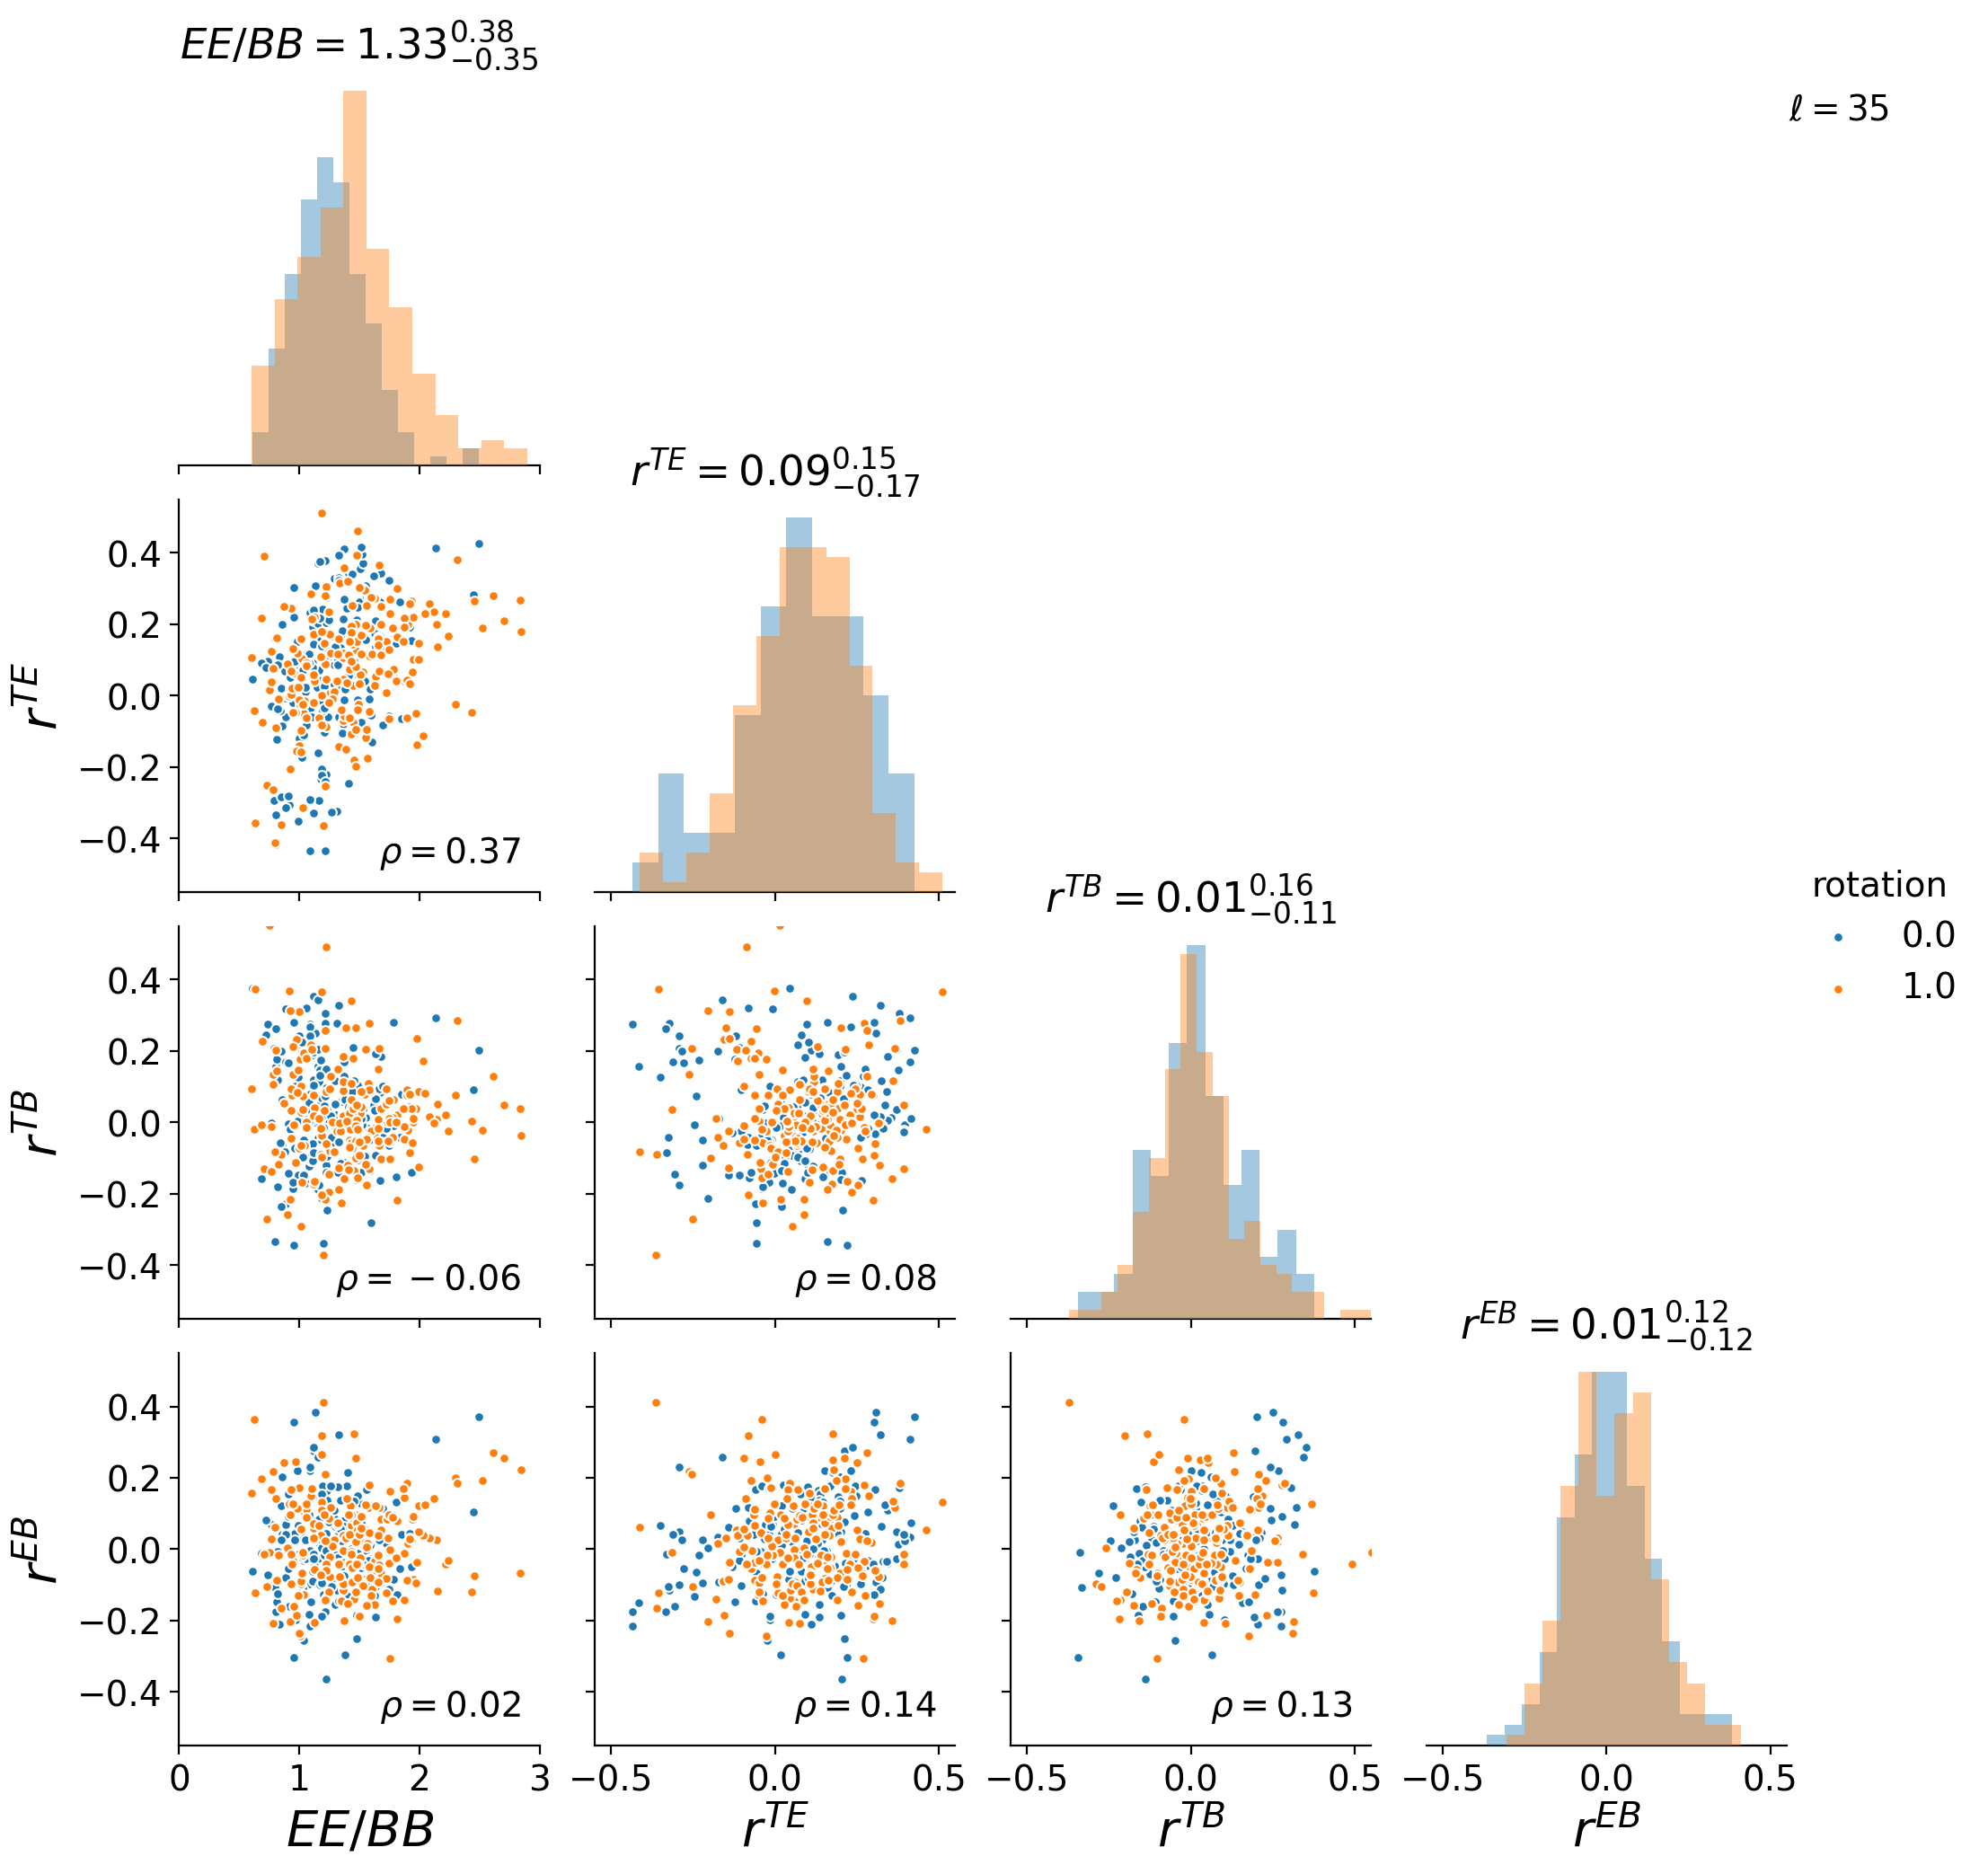

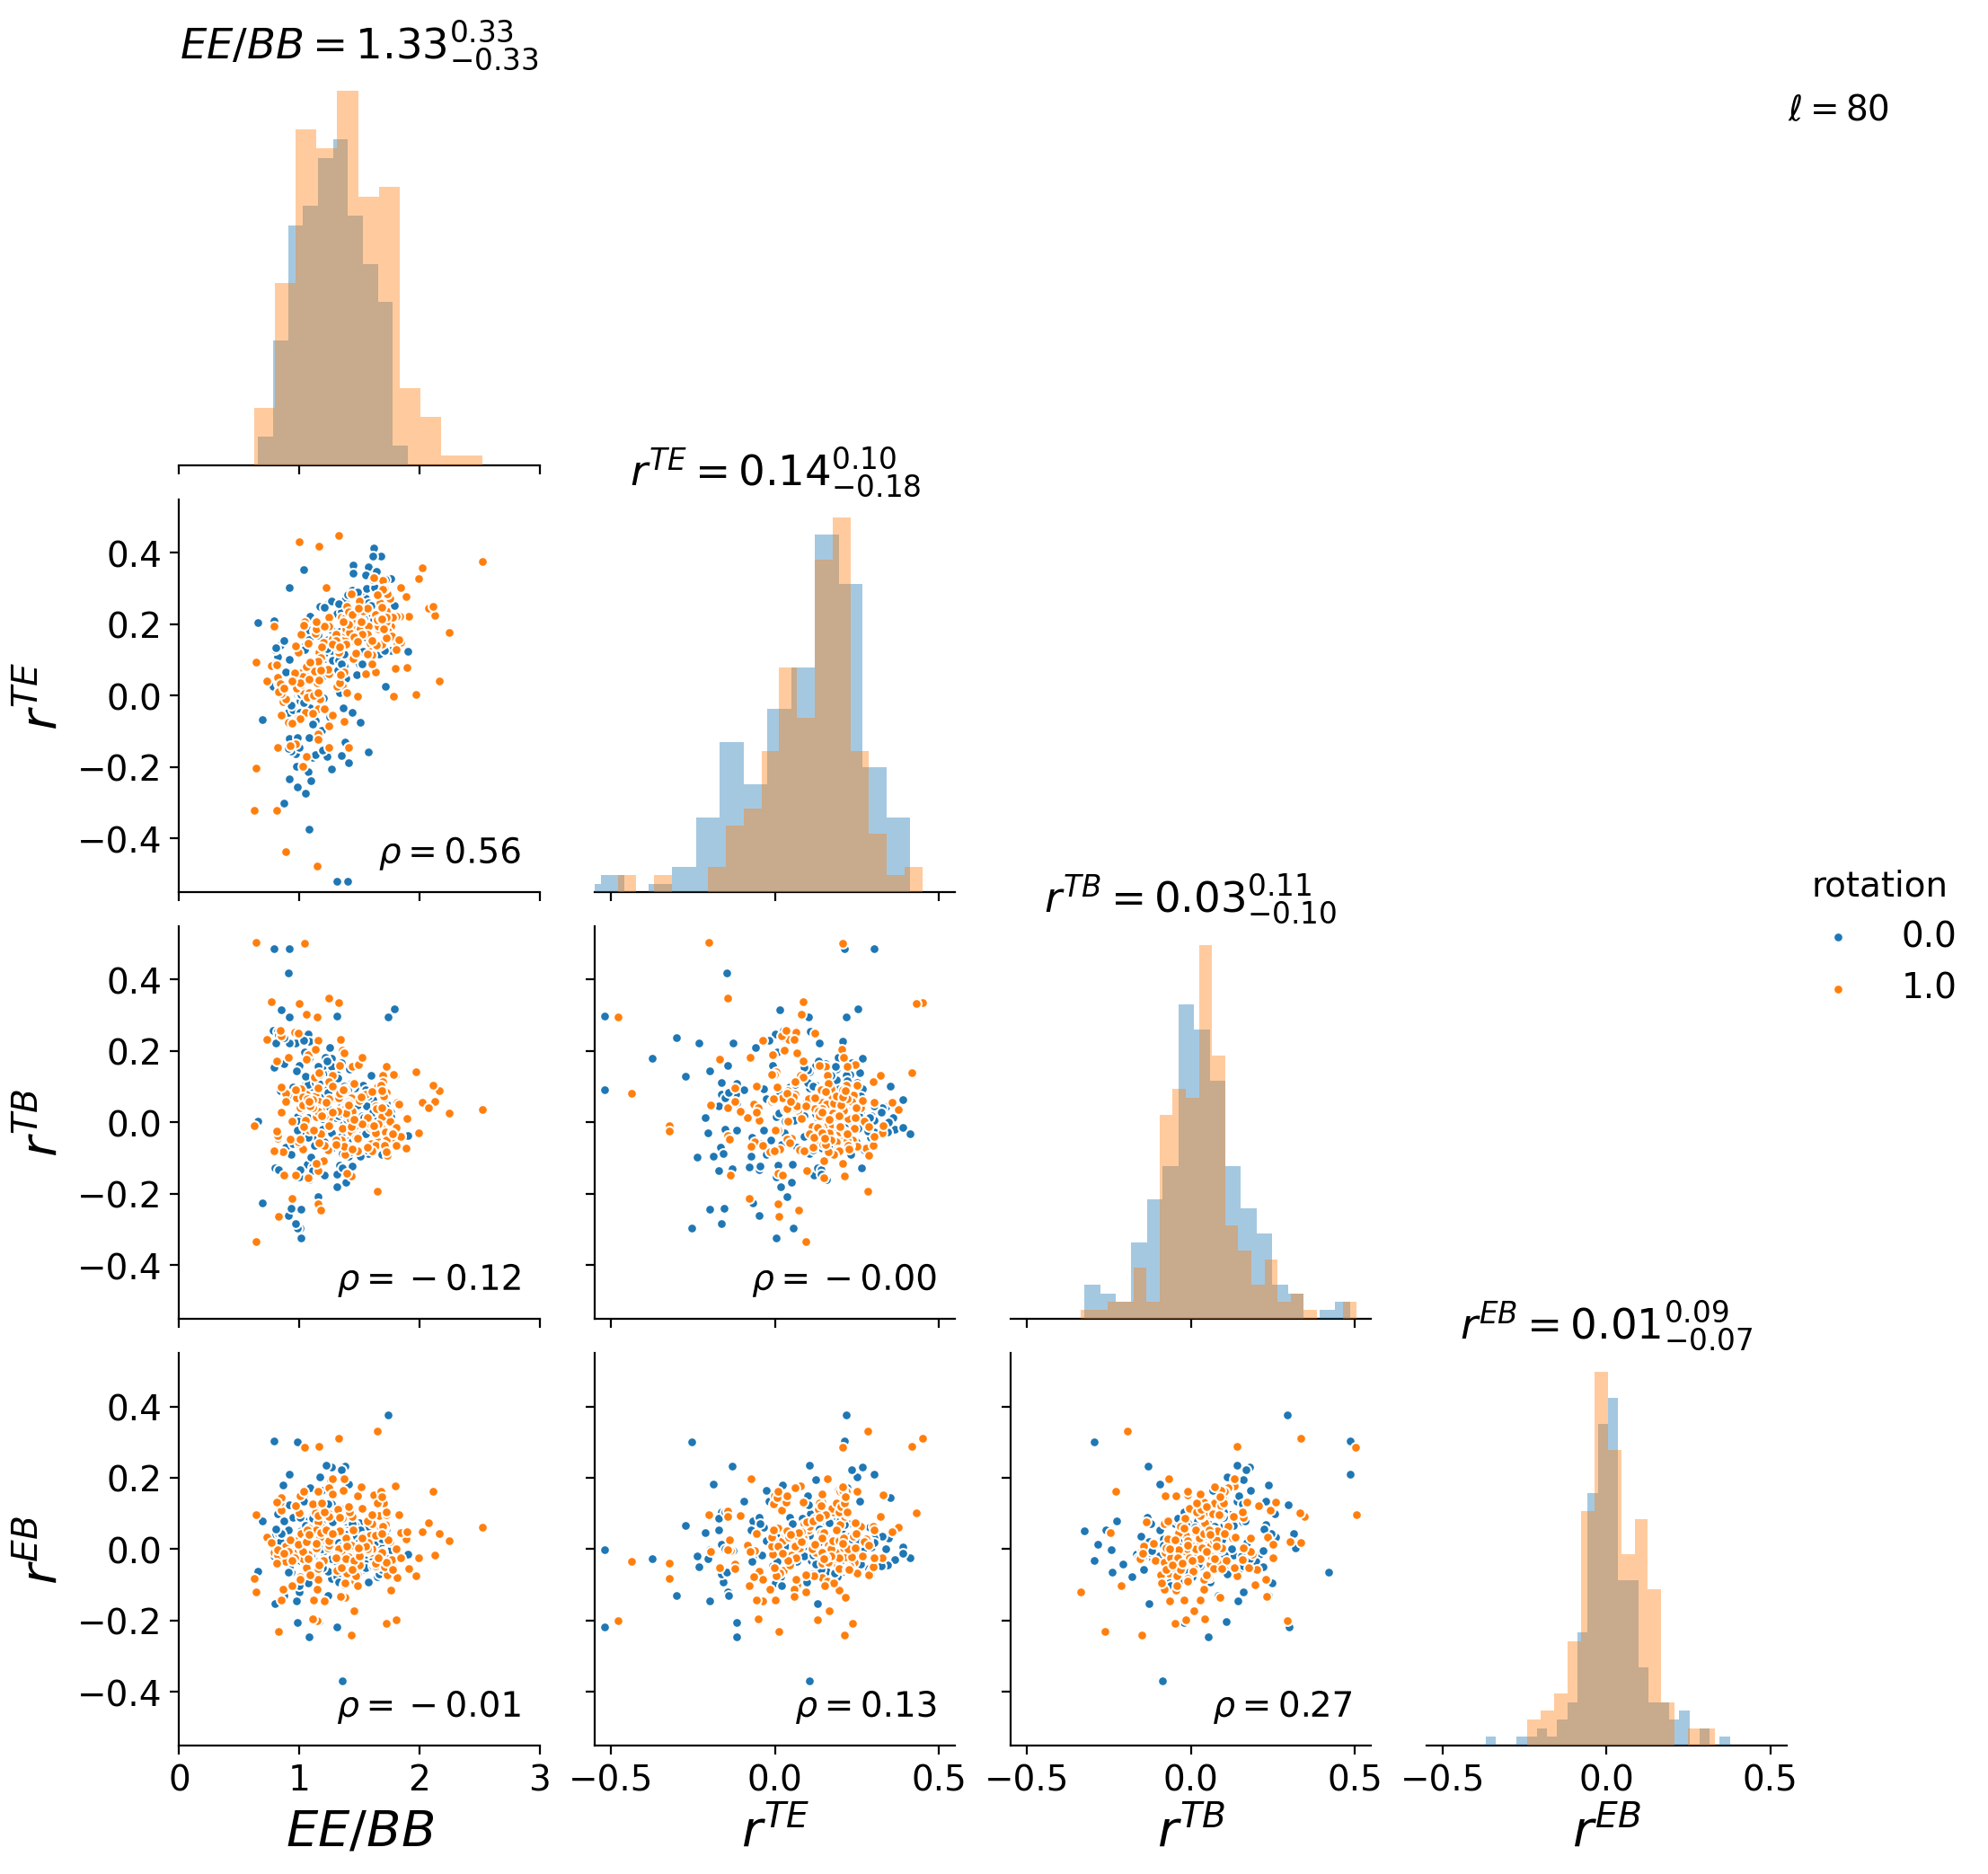

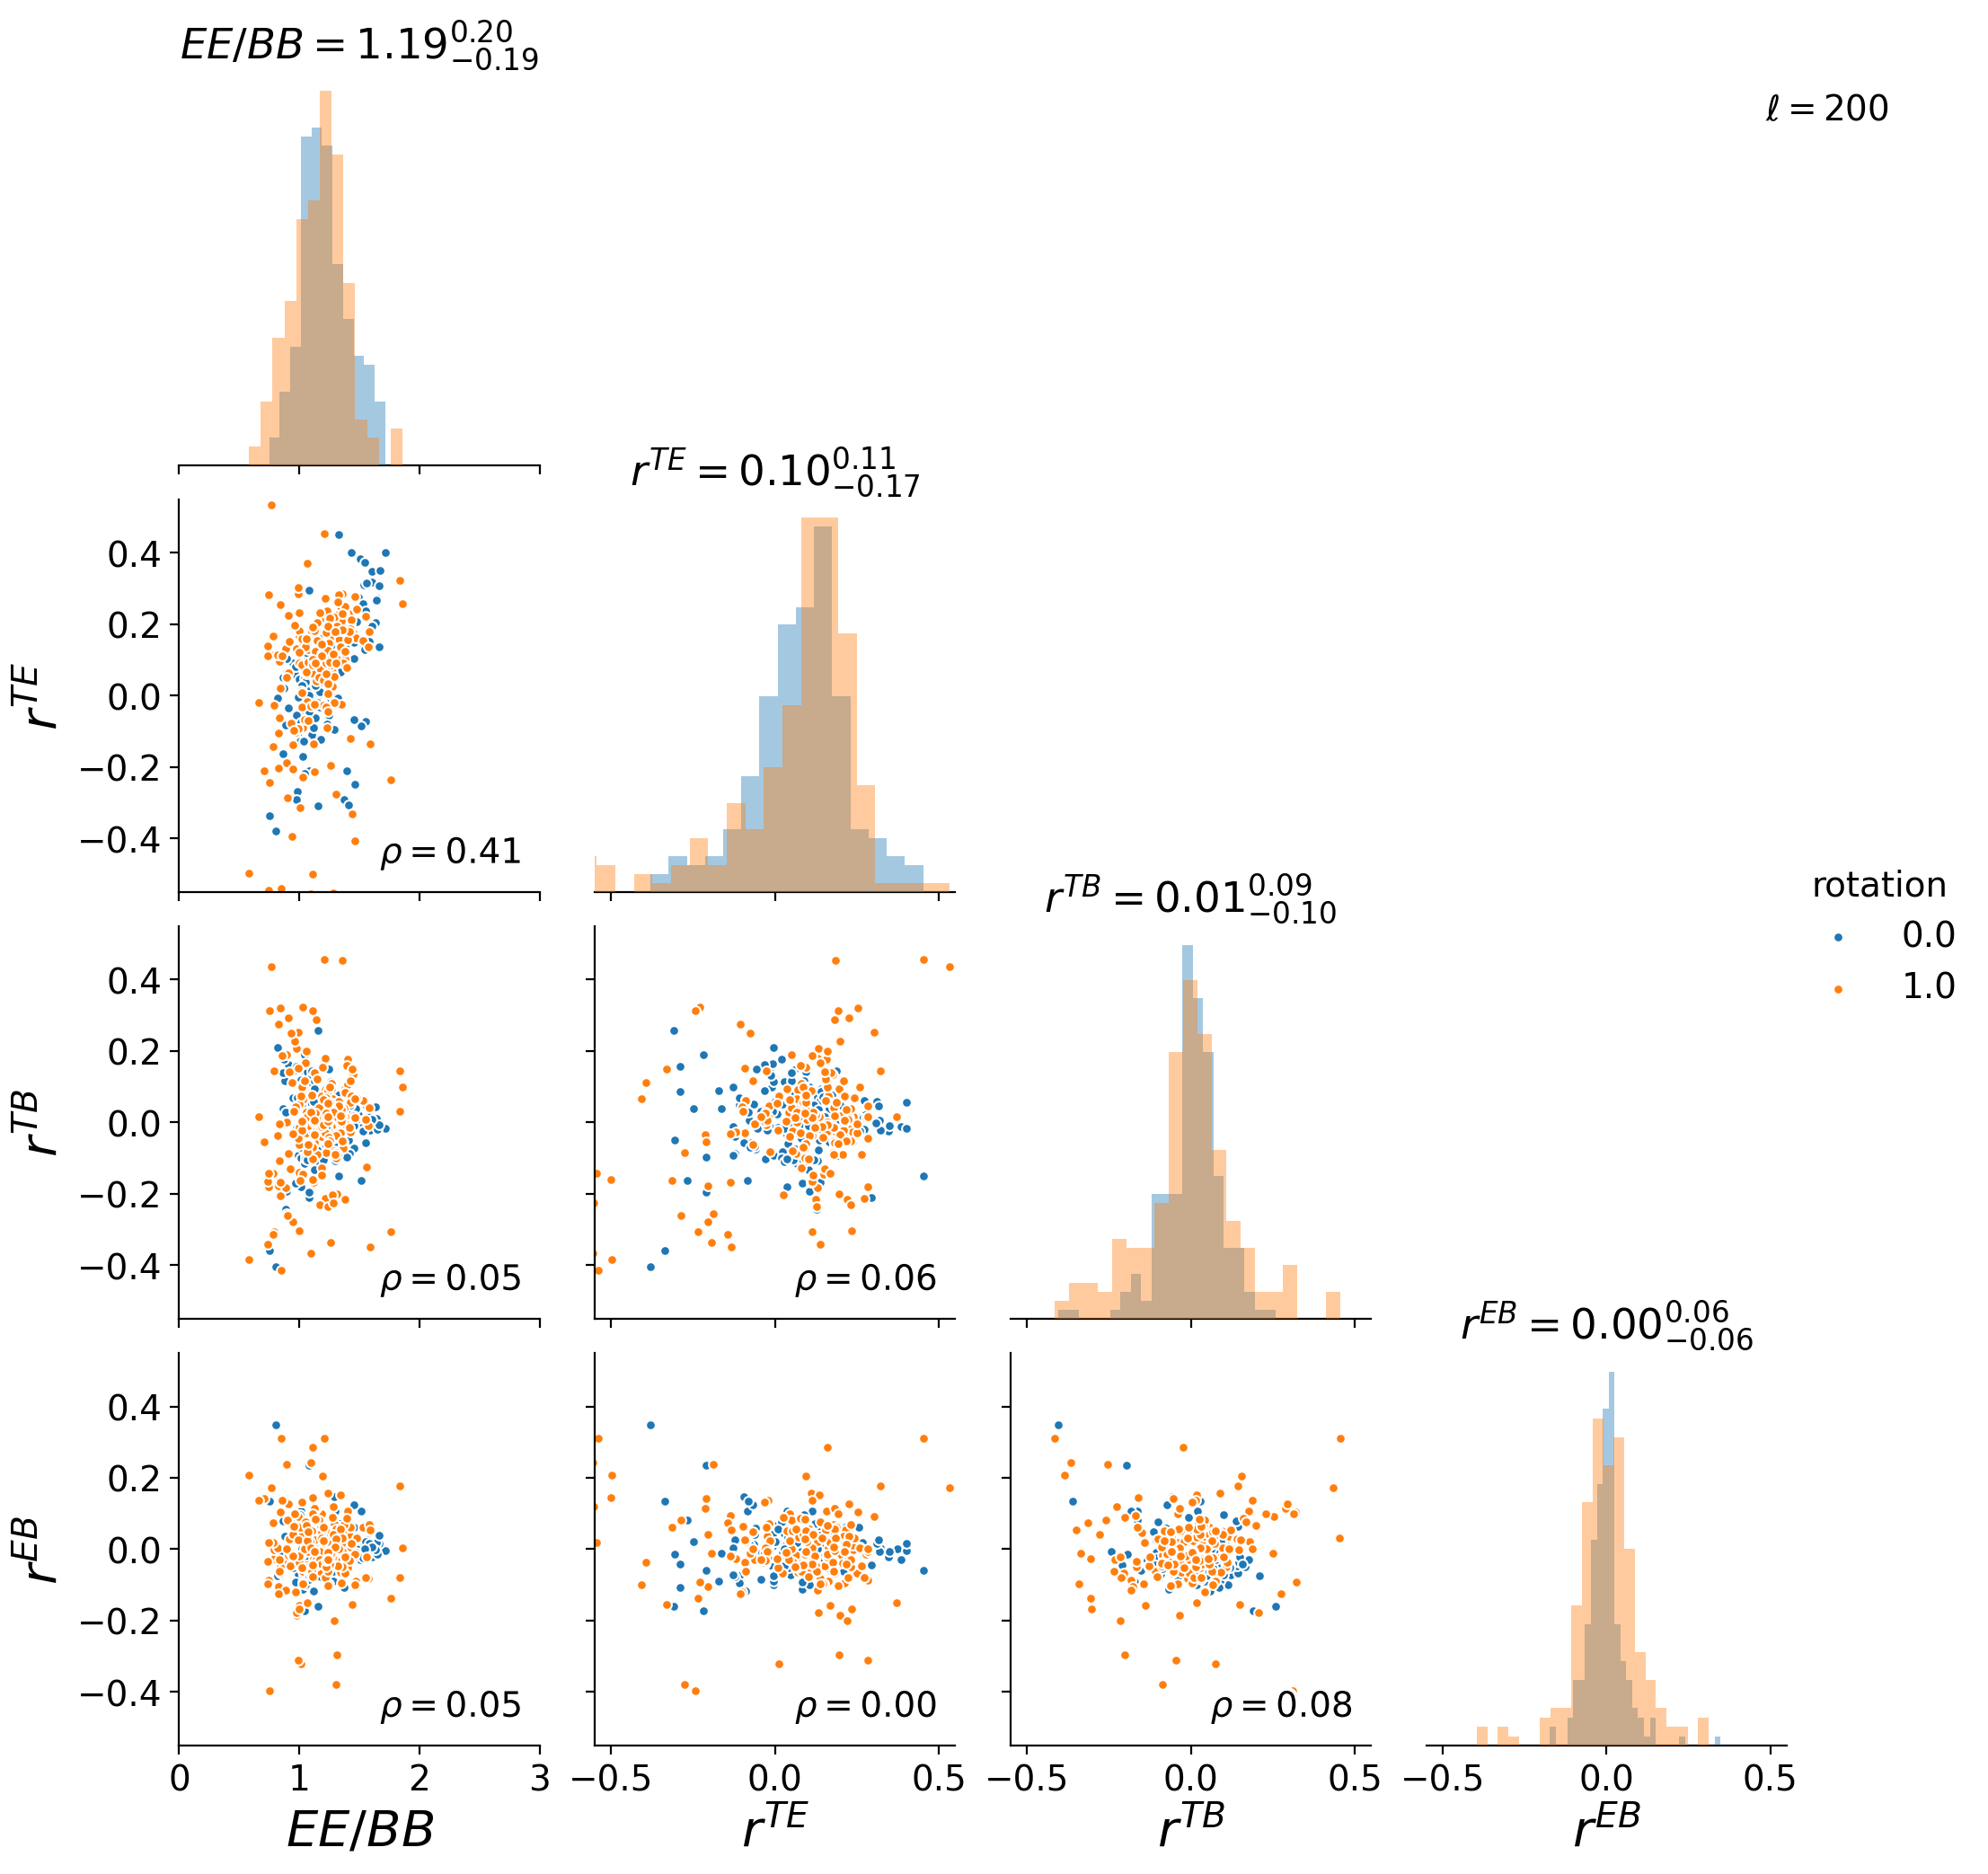

In [15]:
with plt.style.context({'figure.dpi':200,'font.size':14,'axes.labelsize':'x-large'}):
    corr_method='spearman'
#     for dflist,bcut in zip([Ndflist,Sdflist],['b30.N','b30.S']):
#     for rot,dflist in zip(['rot','norot'],[Ndflist,Ndflist_nr]):
    for df,lc in zip(dflist,['l35','l80','l200']):
        df_selected = df#[['EEBB','rTE','rTB','rEB']]
        g = pair_plot_with_corr(df_selected,corr_method=corr_method)
        g.add_legend()
        plt.annotate(r'$\ell=${}'.format(lc[1:]),(.95,0.95),xycoords='figure fraction',ha='right',va='top')
        g.savefig('../figures/rot_{}_{}_{}.png'.format(corr_method,bcut,lc),bbox_inches='tight',dpi=200)

# Correlations in maps with strong TE or TB

rEB rTB 0.6383419256869575 0.03143942899140695
rTB rEB 0.7536566550278136 -0.008663088721391283
95
rEB rTB -0.39070099828116117 0.05669238501828395
rTB rEB -0.2232530231768537 -0.01284584395791161
30
rEB rTE 0.8840643525733297 -0.016698594543621242
rTE rEB 0.3906780672246353 0.047593098602244255
51
rEB rTE -0.5625205350015055 -0.00688483297276229
rTE rEB -0.5928871757318073 -0.014647349719386343
17
rEB rTB 0.6959465777299794 0.021744025728241134
rTB rEB 0.530966746001233 0.014348430457171421
112
rEB rTB -0.8096077725292217 0.059990283516699626
rTB rEB -0.26322764042855384 0.0016762670065187703
17
rEB rTE 1.0625359092911624 -0.02414074904227899
rTE rEB 0.4549816011991471 0.03822991808165667
37
rEB rTE -0.35391447309304175 -0.04641076777800215
rTE rEB -0.49148408090702933 -0.01592179148783371
14
rEB rTB 1.1392059942992079 0.01619834601621748
rTB rEB 0.4846671720048719 -0.009295859806331968
70
rEB rTB -0.8667329245251829 -0.07833973334289598
rTB rEB -0.5826045751735596 -0.0417493576185296

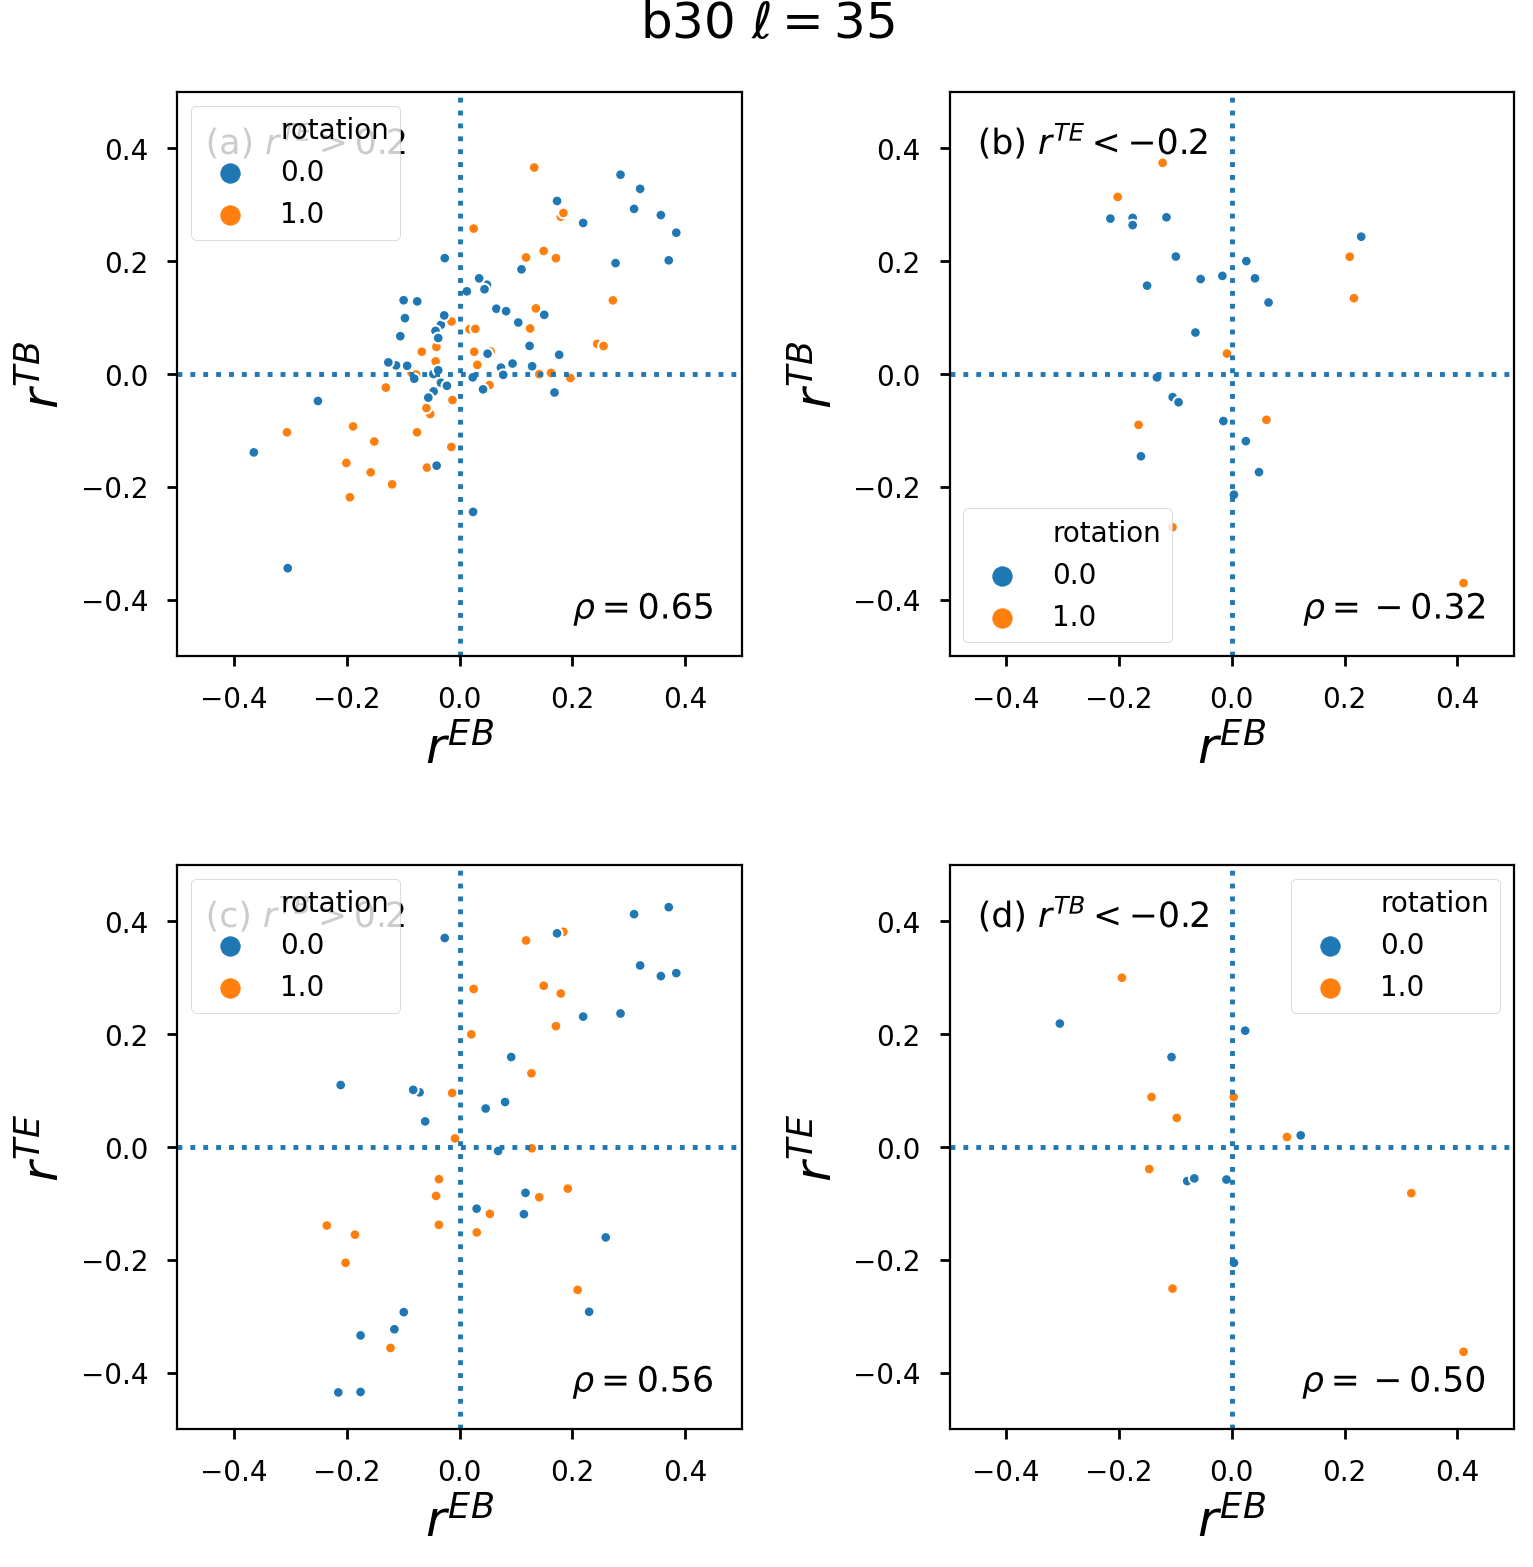

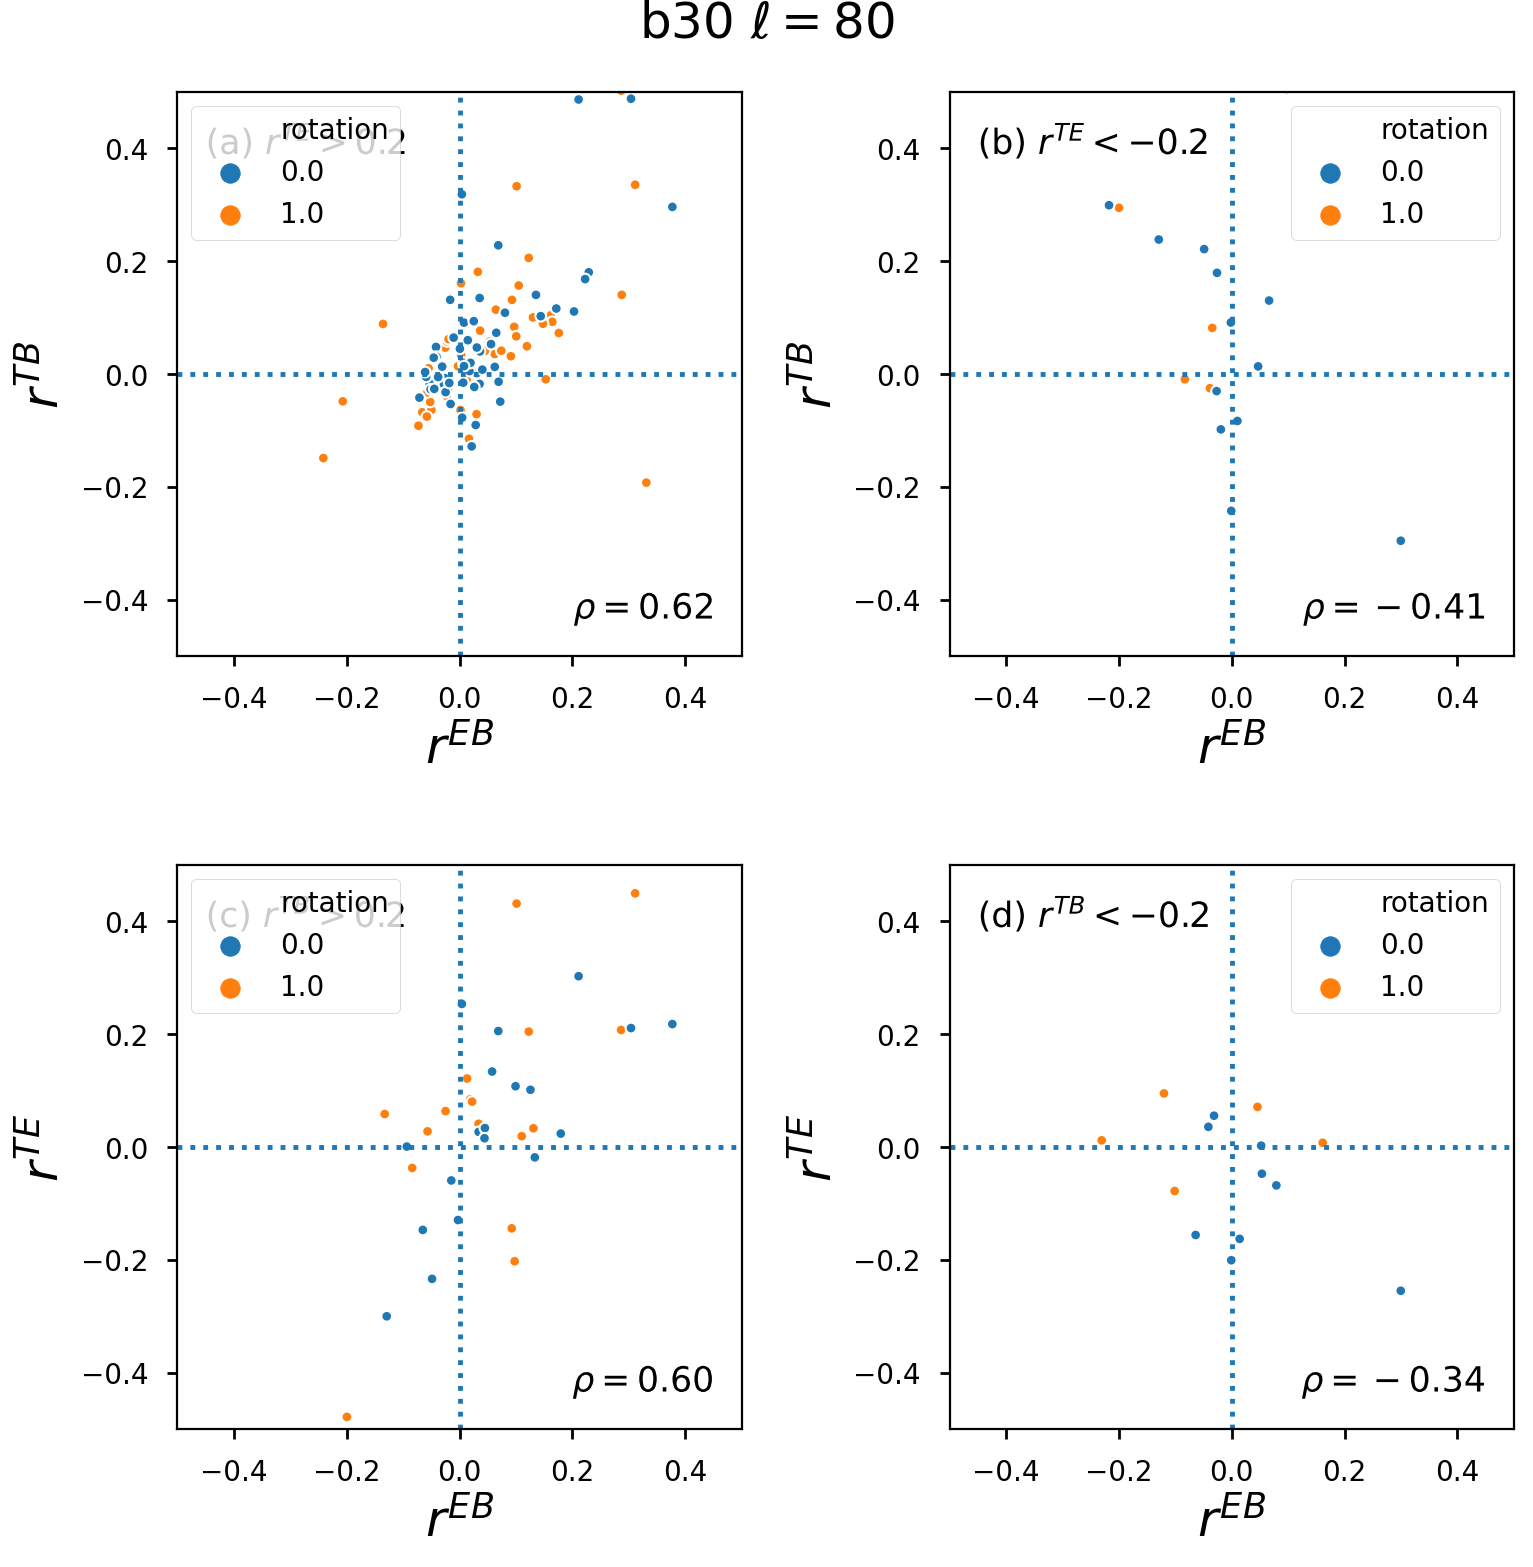

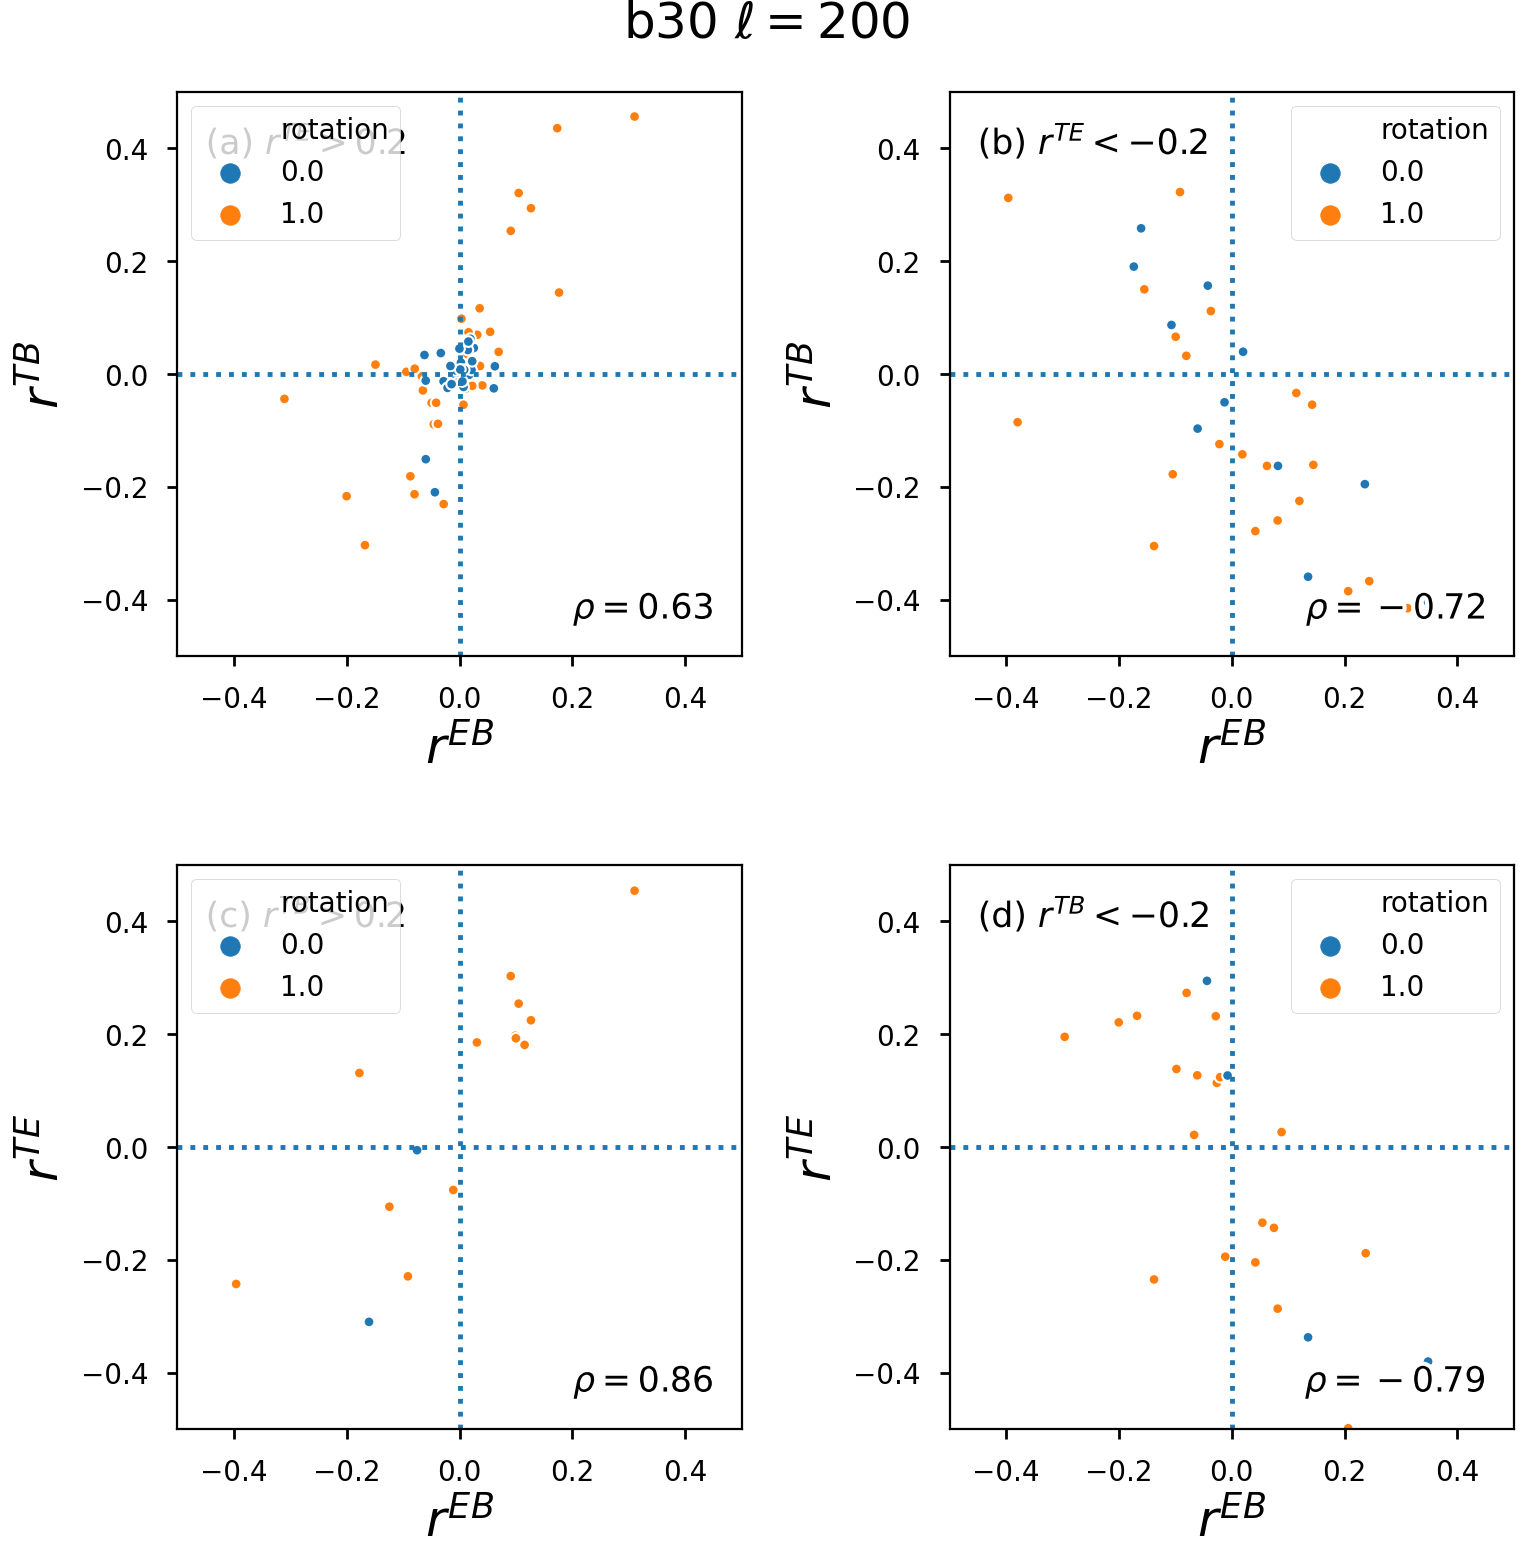

In [16]:
from scipy import stats

with plt.style.context(['seaborn-notebook',{'figure.dpi':200,'font.size':18,'axes.labelsize':'medium'}],after_reset=True):
#     for dflist,bcut in zip([Ndflist,Sdflist],['b30.N','b30.S']):
    bcut = 'b30'
    for df,lc in zip(dflist,['l35','l80','l200']):
        dfpTE = df.where(df.rTE>0.2)[['rTB','rEB','rotation']]
        dfnTE = df.where(df.rTE<-0.2)[['rTB','rEB','rotation']]
        dfpTB = df.where(df.rTB>0.2)[['rTE','rEB','rotation']]
        dfnTB = df.where(df.rTB<-0.2)[['rTE','rEB','rotation']]
        fig,axes = plt.subplots(2,2,figsize=(8,8))
        for ax,x,y,df_,lab in zip(axes.flat,
                                 ['rEB','rEB','rEB','rEB'],
                                 ['rTB','rTB','rTE','rTE'],
                                 [dfpTE,dfnTE,dfpTB,dfnTB],
                                  ['(a) $r^{TE}>0.2$','(b) $r^{TE}<-0.2$','(c) $r^{TB}>0.2$','(d) $r^{TB}<-0.2$']
                                 ):
            plt.sca(ax)
            sns.scatterplot(x,y,hue='rotation',data=df_, s=15)
    #         sns.regplot(x,y,data=df_,scatter_kws=dict(alpha=0.5, s=15))
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_[x].dropna(),df_[y].dropna())
            print(x,y,slope,intercept)
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_[y].dropna(),df_[x].dropna())
            print(y,x,slope,intercept)
            print(len(df_[x].dropna()))

            corr = df_.corr(method=corr_method)

            plt.annotate(lab,(0.05,0.95),ha='left',va='top',xycoords='axes fraction',fontsize='x-small',
                         path_effects=[withStroke(foreground='w',linewidth=3)])
            plt.annotate(r'$\rho={:.2f}$'.format(corr[x][y]),(0.95,0.05),
                         ha='right',va='bottom',xycoords='axes fraction',fontsize='x-small',
                         path_effects=[withStroke(foreground='w',linewidth=3)])
            plt.axhline(0,ls=':')
            plt.axvline(0,ls=':')
            plt.xlim(-0.5,0.5)
            plt.ylim(-0.5,0.5)
    #         plt.plot([-0.3,0.3],[-0.6,0.6])
    #         plt.plot([-0.3,0.3],[0.6,-0.6])
            plt.xlabel(labels_dict[x])
            plt.ylabel(labels_dict[y])
            ax.set_aspect('equal')
        plt.tight_layout()
        plt.annotate(r'{} $\ell=${}'.format(bcut,lc[1:]),(.5,1),xycoords='figure fraction',ha='center',va='top')
#         fig.savefig('../figures/correlation_{}_{}_{}.png'.format(corr_method,bcut,lc),bbox_inches='tight',dpi=200)